# Benchmark test case b7

#### This notebook demonstrates the basic beamforming and deconvolution techniques for noise quantification.

#### Start with loading the data:

In [13]:
# Remember to start with: export JULIA_NUM_THREADS=4
# and FFTW.set_num_threads(2)
using HDF5, GR, AeroAcoustics
inline()

#FFTW.set_num_threads(2)

# load data:
csm_path = "/Users/oliver/Documents/AeroAcoustic_benchmarks/Simulated/b7/ab7aCsmEss.h5"
csm_Ref = "/Users/oliver/Documents/AeroAcoustic_benchmarks/Simulated/b7/ab7aCsmOpt.h5"
time_path = "/Users/oliver/Documents/AeroAcoustic_benchmarks/Simulated/b7/ab7TimeSeries.h5"

data = read(h5open(csm_path))
dataref = read(h5open(csm_Ref))
f = data["CsmData"]["binCenterFrequenciesHz"]
micgeom = data["MetaData"]["ArrayAttributes"]["microphonePositionsM"]

SourcePos = Dict{String, Dict{String,Tuple}}() 
SourcePos["Source3"] = Dict([("xy",(0.1,0.1))])
SourcePos["Source0"] = Dict([("xy",(0.1,-0.1))])
SourcePos["Source1"] = Dict([("xy",(-0.1,-0.1))])
SourcePos["Source2"] = Dict([("xy",(-0.1,0.1))])

Dict{String,Tuple{Float64,Float64}} with 1 entry:
  "xy" => (-0.1, 0.1)

#### Setup grid and beamforming...

In [ ]:
# Set frequency range:
@time begin
fco = 10.^(3.2:0.1:4.31)        # Center frequencies of interest
fl,fu = octavebandlimits(fco,3) # Calculate third-octave band limits

# Setup grid and limits:
dx, dy = 0.025,0.025    # Grid size
x = [-0.5,0.5]          # x limits 
y = x                   # y limits
z = 0.75                # Measurement distance

# Create beamformer environment:
Env = beamformersetup(dx,dy,x,y,z,[fl[1];fu[end]],micgeom,csm_path)

# Declare constants:
Const = Constants(0.0,343.0)

# Calculate steering vectors:
V = steeringvectors(Env,Const)

# Calculate beamformer output and point-spread function:
b = beamformer(Env,Const,V)
PSF = pointspreadfunction(Env,Const,V)
println("Finished setup...")
end

Finished setup...
  8.136889 seconds (10.16 M allocations: 4.067 GiB, 7.29% gc time)


#### Plot beamforming results and point spread function

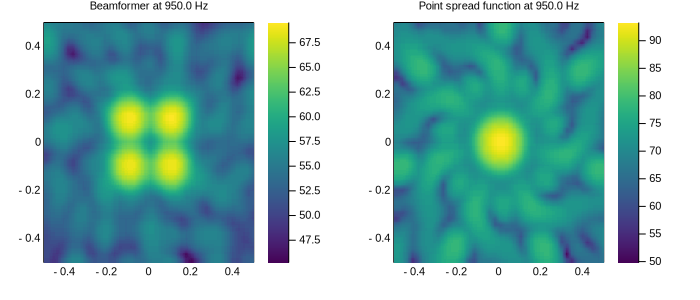

In [ ]:
# Plot result
indf = 20
figure(size=(700,300))
subplot(1,2,1)
contourf(Env.rx,Env.ry,SPL(b[:,:,indf]),title="Beamformer at $(f[indf]) Hz")
subplot(1,2,2)
contourf(Env.rx,Env.ry,SPL(PSF[:,:,indf]),title="Point spread function at $(f[indf]) Hz")

#### Perform deconvolution...

In [ ]:
# Deconvolution without boundary-conditions
X0 = zeros(Env.Nx,Env.Ny)
x_fistaprox = zeros(Env.Nx,Env.Ny,Env.Nf)
kmax = 100
tol = 1e-6
@time fistaprox!(x_fistaprox, PSF, b, NormL1Pos();tol=tol,maxit=kmax,lam=0.003);
@time x_fista,objs = fista(PSF, b, X0, kmax,-Inf);

 75.076703 seconds (11.31 M allocations: 14.375 GiB, 2.32% gc time)
 74.521332 seconds (11.41 M allocations: 14.974 GiB, 2.44% gc time)


#### Plot deconvolution results...

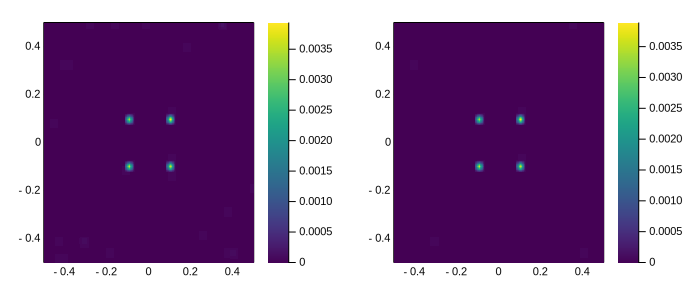

In [ ]:
figure(size=(700,300))
fin = 100
subplot(1,2,1)
contourf(Env.rx,Env.ry,x_fista[:,:,fin])
subplot(1,2,2)
contourf(Env.rx,Env.ry,x_fistaprox[:,:,fin])

#### Do source integration for noise quantification...

In [ ]:
# Source integration:
integration_area = (0.1,0.1)
res_fista = sourceintegration(x_fista,SourcePos,Env,fco,integration_area)
res_fistaprox = sourceintegration(x_fistaprox,SourcePos,Env,fco,integration_area)

# Calculate reference values from dataset:
SourceRef = Dict{String, Array{Float64,1}}() 
SourceRef["fco"] = fco
for (key,value) in SourcePos
    tsrc = similar(fco)
    for i in 1:length(fco)
        fn = f[(f.>=fl[i]) .& (f.<=fu[i])]
        ind = findin(f,fn)
        tsrc[i] = SPL(sum(dataref["RefData"][key]["thirdOctBandReference"][i]))
    end
    SourceRef[key] = tsrc
end

#### And plot results...

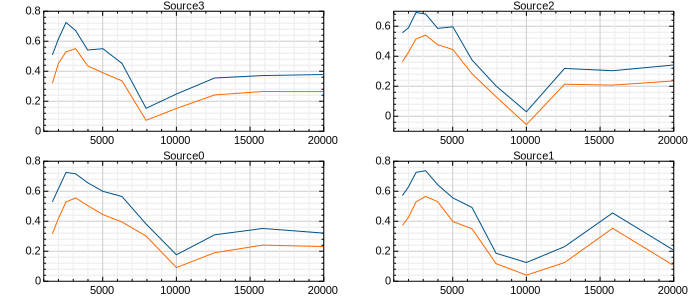

In [38]:
#plot results:
src = collect(keys(SourcePos))
diff1 = [res_fista[src[1]] res_fistaprox[src[1]]].-SourceRef[src[1]]
diff2 = [res_fista[src[2]] res_fistaprox[src[2]]].-SourceRef[src[2]]
diff3 = [res_fista[src[3]] res_fistaprox[src[3]]].-SourceRef[src[3]]
diff4 = [res_fista[src[4]] res_fistaprox[src[4]]].-SourceRef[src[4]]

subplot(2,2,1)
plot(SourceRef["fco"],diff1,title="$(src[1])")
subplot(2,2,2)
plot(SourceRef["fco"],diff2,title="$(src[2])")
subplot(2,2,3)
plot(SourceRef["fco"],diff3,title="$(src[3])")
subplot(2,2,4)
plot(SourceRef["fco"],diff4,title="$(src[4])")